In [7]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization import *
from ourmodel import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 1000

PATH_MNISTC = '../data/MNIST_C/'
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']



ACC_TYPE = "entropy"

#################
# model load
################
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

def recon_loss_step(x_recon_step, x, time_steps):
    '''
    mse loss is used for reconstruction loss over all steps
    '''
    losses= []
    for t in range(time_steps):
        x_recon= x_recon_step[:,t]
        ls = nn.MSELoss(reduction='none')(x_recon, x) # 1000, 1, 28, 28
        ls = ls.flatten(start_dim=1)
        ls = ls.mean(dim=1)
        losses.append(ls)
        
    return torch.stack(losses, dim=1) # 1000 x 5

@torch.no_grad()
def evaluate_model_on_mnistc_original(corruption, model, max_batch_num=None):
    path_images = os.path.join(PATH_MNISTC, corruption, 'test_images.npy')
    path_labels = os.path.join(PATH_MNISTC, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)
    
    losses_all, objcaps_len_step_all, acc_all = [],[], []
    
    model.eval()      
    
    # get input and gt
    i=0
    for data in dataloader:
        
        if max_batch_num:
            if i == max_batch_num:
                break
#         if i == max_batch_num:
#             x, y = data
#             gtx = None

        x, y = data
        gtx = None
        # evaluate and append results 
        loss, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_type=ACC_TYPE, gtx=gtx)

        # append loss and objcaps prediction 
        losses = recon_loss_step(x_recon_step, x.to(x_recon_step.device), objcaps_len_step.shape[1])

        losses_all.append(losses)
        acc_all.append(acc)
        objcaps_len_step_all.append(objcaps_len_step)
        
        i+=1
    
    # concat and add to outputs dictionary
    losses_all = torch.cat(losses_all, dim=0)
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)

    return objcaps_len_step_all, losses_all, acc_all
    

@torch.no_grad()
def evaluate_model_on_expstimuli(expname, model, args, verbose=True, save_hooks=False):
    
    model.eval()  
    
    # get corruption batch information
#     corruption_id = int(CORRUPTION_TYPES.index(corruption))
#     num_batch_required = int(N_MINI_PER_CORRUPTION/BATCHSIZE) # if batchsize 100; 10 batches are requried
    
    # load dataloader and iterator
    dataloader = fetch_dataloader(expname, DATA_DIR, DEVICE, BATCHSIZE, train)    
    diter = iter(dataloader)

    if save_hooks:
        def get_attention_outputs():
            def hook(model, input, output):
                x_mask_step.append(output[0].detach())
                x_input_step.append(output[1].detach())
            return hook

        def get_capsule_outputs():
            def hook(model, input, output):
                objcaps_step.append(output[0].detach())
                coups_step.append(torch.stack(output[1]['coups'], dim=1))
                betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
                if 'rscores' in output[1].keys():
                    rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
                if 'recon_coups' in output[1].keys():
                    recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
                if 'outcaps_len' in output[1].keys():
                    outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
                if 'outcaps_len_before' in output[1].keys():
                    outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
            return hook
        
        outputs = {}

        x_input_step_all = []; x_mask_step_all = []; objcaps_step_all = []

        coups_step_all = []; betas_step_all= []; rscores_step_all=[]; recon_coups_step_all=[] 
        outcaps_len_step_all=[]; outcaps_len_before_step_all=[]

    x_all, y_all, gtx_all, loss_all, acc_all, objcaps_len_step_all, x_recon_step_all = [],[],[],[],[],[],[]
          
    
    for i in range(0, len(diter)):
        x, y = next(diter)
        gtx = None
            
        # for hooks over other model output
        x_input_step = []; x_mask_step = []; objcaps_step = []

        if save_hooks:

            # for hooks over dynamic routing
            coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
            outcaps_len_step=[]; outcaps_len_before_step=[]

            hook1 = model.input_window.register_forward_hook(get_attention_outputs())
            hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())

        # evaluate and append results 
        losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_type=ACC_TYPE, gtx=gtx)
        
        if verbose:
            print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                  % (losses[0], losses[1], losses[2], acc.mean()))   
            
        # main input and output append
        x_all.append(x)
        y_all.append(y)
        if gtx:
            gtx_all.append(gtx)
        #         loss_all.append(losses[0])
        acc_all.append(acc)
        objcaps_len_step_all.append(objcaps_len_step)
        x_recon_step_all.append(x_recon_step)
        
        if save_hooks:
        
            # hook variables append
            x_input_step_all.append(torch.stack(x_input_step, dim=1))
            x_mask_step_all.append(torch.stack(x_mask_step, dim=1))
            objcaps_step_all.append(torch.stack(objcaps_step, dim=1))

            coups_step_all.append(torch.stack(coups_step, dim=1))
            betas_step_all.append(torch.stack(betas_step, dim=1))
            if rscores_step:
                rscores_step_all.append(torch.stack(rscores_step, dim=1))
            if recon_coups_step:
                recon_coups_step_all.append(torch.stack(recon_coups_step, dim=1))
            if outcaps_len_step:
                outcaps_len_step_all.append(torch.stack(outcaps_len_step, dim=1))
            if outcaps_len_before_step:
                outcaps_len_before_step_all.append(torch.stack(outcaps_len_before_step, dim=1))

            hook1.remove()
            hook2.remove()
    
        
    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    if gtx:
        gtx_all = torch.cat(gtx_all, dim=0)
    else:
        gtx_all = gtx
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    
    if save_hooks:
        outputs['x_input']= torch.cat(x_input_step_all, dim=0)
        outputs['x_mask']= torch.cat(x_mask_step_all, dim=0)
        outputs['objcaps']= torch.cat(objcaps_step_all, dim=0)

        outputs['coups'] = torch.cat(coups_step_all, dim=0)
        outputs['betas'] = torch.cat(betas_step_all, dim=0)
        if rscores_step_all:
            outputs['rscores'] = torch.cat(rscores_step_all, dim=0)
        if recon_coups_step_all:
            outputs['recon_coups'] = torch.cat(recon_coups_step_all, dim=0)
        if outcaps_len_step_all:
            outputs['outcaps_len'] = torch.cat(outcaps_len_step_all, dim=0)
        if outcaps_len_before_step_all:
            outputs['outcaps_len_before'] = torch.cat(outcaps_len_before_step_all, dim=0)
            
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all, outputs  

    else:
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all

# load model

In [8]:
#############################
# arguments to change
#############################

# task and dataset
task='mnist_c_exp'

train=False #train or test dataset

# model and args load
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 5, 'routings': 3, 'mask_threshold': 0.1}

load_model_path = './models/our-resnet/run1.pt'

###############################
# load model and model output
###############################
args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)


# corruption_index =12
# corruption =CORRUPTION_TYPES[corruption_index-1]
# print('analysis on ', corruption)

# print("original is used")
# objcaps_len_step, losses, acc = \
# evaluate_model_on_mnistc_original(corruption, model, max_batch_num=None)
# print(f'==> corruption type: {corruption}, this batch acc: {acc.mean().item()}')




=========== model instantiated like below: =============
TASK: mnist_recon_low (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 5
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match



In [9]:
x, gtx, y, acc, objcaps_len_step, x_recon_step, outputs = \
evaluate_model_on_expstimuli('mnist_c_exp1', model, args, verbose=True, save_hooks=True)

==> On this sigle test batch: test_loss=0.37043, test_loss_class=0.27680, test_loss_recon=0.23884, test_acc=1.0000


In [10]:
# compute stepwise entropy
from torch.distributions import Categorical
from copy import deepcopy

# copy capslen
capslen = deepcopy(outputs['outcaps_len'])
T=0.2
capslen = F.softmax(capslen/T, dim=-1)
print(capslen.shape)

# get entropy
dist = Categorical(probs=capslen)
entropy = dist.entropy()
print(entropy.shape)

torch.Size([480, 5, 3, 10])
torch.Size([480, 5, 3])


# Visualization 

In [4]:
import math
from matplotlib.ticker import MultipleLocator
import pandas as pd
from matplotlib.colors import ListedColormap
import numpy as np

In [11]:
files = np.load('../data/MNIST_C/minstc_exp1_filename.npy')
df = pd.DataFrame()

threshold=0.6
bools = (entropy.view(len(entropy),-1)<threshold)*1
# bools[:,0:2]=-99
# get first true index along second axis
index = bools.argmax(dim=1)

# set index to 14 for rows with all false values
# mask = bools.sum(dim=1) == -99*2
mask = bools.sum(dim=1) == 0

index[mask] = 14

df['filename'] = list(files)
df['nstep'] = index.cpu().numpy()
df.to_csv('nstep.csv', index=False)



tensor(165, device='cuda:0') tensor(156, device='cuda:0') tensor(159, device='cuda:0')


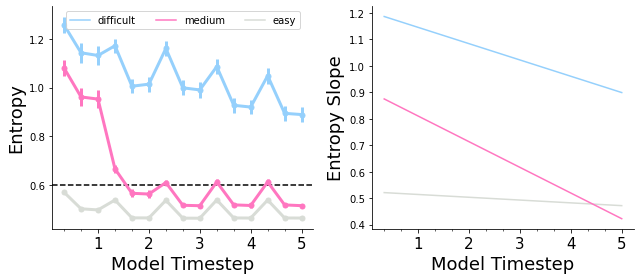

In [12]:
#####
# low-mid-high
####

low = (0<=index) & (index<3)
mid = (3<=index) & (index<9)
high= (9<=index) & (index<15)
print(low.sum(), mid.sum(), high.sum()) # it should be 160, 160, 160 by coarse timestep, 

# create a figure and axis object
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))


# Define a list of light blue, pink, and gray colors
colors = ["xkcd:light grey",  '#ff76c0',  "xkcd:light blue"]
# lightcolors = ['#d9d9d9',  '#ff99cc', '#87ceeb']
i=0
for name, index in zip(['easy','medium', 'difficult'],[low, mid, high]):
    
#     if corruption=='fog':
#         continue
    ent = entropy[index]
    average = ent.mean(dim=0).flatten().cpu().numpy()
    se = (ent.std(dim=0).flatten().cpu().numpy())/math.sqrt(len(ent)-1)
#     se = (ent.std(dim=0).flatten().cpu().numpy())

    x = torch.arange(len(average))
    ax1.errorbar(x, average, marker='o', markersize=5, yerr=se, label=name, color=colors[i],  linewidth=3) #1.96se is 95 interval
#     ax1.plot(x, average,  label=name, color=colors[i]) #  marker='o', markersize=4,
#     ax1.fill_between(x, average-1.96*se, average+1.96*se, color=colors[i], alpha=0.2)
    slope, intercept = np.polyfit(x, average, 1)
    y_fit = slope * x + intercept
    ax2.plot(x, y_fit, label=name, color=colors[i])
    
    i+=1
    


# hide the top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# set the axis labels and title
ax1.set_xlabel('Model Timestep', fontsize=18)
ax1.set_ylabel('Entropy', fontsize=18)

ax2.set_xlabel('Model Timestep', fontsize=18)
ax2.set_ylabel('Entropy Slope', fontsize=18)
# ax.set_title('Capsule Entropy')

# set the xticks to show a major tick every three minor ticks
minorLocator = MultipleLocator(1)
majorLocator = MultipleLocator(3)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.xaxis.set_major_locator(majorLocator)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.xaxis.set_major_locator(majorLocator)

# set the tick labels to show 1, 2, 3, 4, 5
ax1.set_xticks(range(2, 17, 3), ['1', '2', '3', '4', '5'], fontsize=15)
ax2.set_xticks(range(2, 17, 3), ['1', '2', '3', '4', '5'], fontsize=15)




handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]


ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center',  ncol=3)
ax1.axhline(y=0.6, color='black', linestyle='--')


plt.tight_layout()
fig.savefig('difficulty_entropy.pdf', format='pdf', dpi=300)

plt.show()



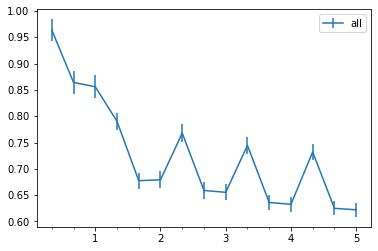

In [100]:
############
# grand average
###########
# set the xticks to show a major tick every three minor ticks
minorLocator = MultipleLocator(1)
majorLocator = MultipleLocator(3)
plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gca().xaxis.set_major_locator(majorLocator)

# set the tick labels to show 1, 2, 3, 4, 5
plt.xticks(range(2, 17, 3), ['1', '2', '3', '4', '5'])



ent = entropy
average = ent.mean(dim=0).flatten().cpu().numpy()
se = (ent.std(dim=0).flatten().cpu().numpy())/math.sqrt(len(ent))

x = torch.arange(len(average))
plt.errorbar(x, average, yerr=se, label='all')

slope, intercept = np.polyfit(x, average, 1)

plt.legend()
plt.show()

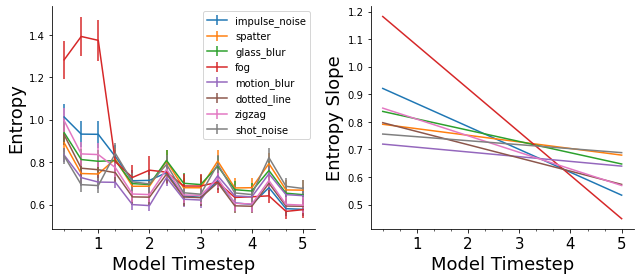

In [302]:
#####
# corruption wise
####
corruptions = ['impulse_noise', 'spatter', 'glass_blur', 'fog', 
 'motion_blur', 'dotted_line', 'zigzag', 'shot_noise']

# create a figure and axis object
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))


df = pd.DataFrame()
df['corruption']= corruptions


for ci, corruption in enumerate(corruptions):
#     if corruption=='fog':
#         continue
    ent = entropy[60*ci:60*ci+60]
    average = ent.mean(dim=0).flatten().cpu().numpy()
    se = (ent.std(dim=0).flatten().cpu().numpy())/math.sqrt(len(ent))
    
    x = torch.arange(len(average))
    ax1.errorbar(x, average, yerr=se, label=corruption)
    
    slope, intercept = np.polyfit(x, average, 1)
    y_fit = slope * x + intercept
    ax2.plot(x, y_fit, label=corruption)
    
    df.loc[ci, 'slope']= slope
    df.loc[ci, 'intercept']= intercept
    




# hide the top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# set the axis labels and title
ax1.set_xlabel('Model Timestep', fontsize=18)
ax1.set_ylabel('Entropy', fontsize=18)

ax2.set_xlabel('Model Timestep', fontsize=18)
ax2.set_ylabel('Entropy Slope', fontsize=18)
# ax.set_title('Capsule Entropy')

# set the xticks to show a major tick every three minor ticks
minorLocator = MultipleLocator(1)
majorLocator = MultipleLocator(3)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.xaxis.set_major_locator(majorLocator)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.xaxis.set_major_locator(majorLocator)

# set the tick labels to show 1, 2, 3, 4, 5
ax1.set_xticks(range(2, 17, 3), ['1', '2', '3', '4', '5'], fontsize=15)
ax2.set_xticks(range(2, 17, 3), ['1', '2', '3', '4', '5'], fontsize=15)


ax1.legend(loc='upper right')

plt.tight_layout()
fig.savefig('all_corruption_entropy.pdf', format='pdf', dpi=300)

plt.show()



In [98]:
df.sort_values(by='intercept', ascending=False)

,corruption,slope,intercept
3,fog,-0.052382,1.181987
0,impulse_noise,-0.027655,0.921126
6,zigzag,-0.020048,0.849693
2,glass_blur,-0.013620,0.837693
5,dotted_line,-0.015990,0.796881
1,spatter,-0.007989,0.791075
7,shot_noise,-0.004813,0.755608
4,motion_blur,-0.005708,0.719202


In [136]:
# get filewise slope
files = np.load('../data/MNIST_C/minstc_exp_filename.npy')
df = pd.DataFrame()
df['filename'] = list(files)
for i in range(len(entropy)):
    ent = entropy[i].flatten().cpu().numpy()  
    x = torch.arange(len(ent))
    slope, intercept = np.polyfit(x, ent, 1)
    y_fit = slope * x + intercept    
    df.loc[i, 'slope']= slope
    df.loc[i, 'intercept']= intercept

In [138]:
df.to_csv('exp1_entropy_slope.csv', index=False)